<font size="6">**Water flow and tsunami modelisation with python**</font>

---
This notebook has been designed to explain and illustrate in detail the different methods, equations and code used to model a tsunami in the context of  the course LBRTI2102 - Process-based modelling in bioscience engineering

In almost all of it we used a python package named [Clawpack](http://www.clawpack.org/).
For more information about, see [this paper](http://epubs.siam.org/doi/abs/10.1137/110856976).

We'll start by explaining the basic operations of the package by clarifying the PDE solver via a classic 1D advection acoustic expamples. We will then use the 1D shallow water equations to modelize a wave beeing trapped on a continental shelf.

We will afterward modelize 2 dimentional shallow water equations and apply those equations to modelize the wave formed by the [2010 Chile earthquake](https://en.wikipedia.org/wiki/2010_Chile_earthquake).

Finally, we will confront our model with real data to see how it has performed.

\


To navigate this Notebook you just have to click on the play icon next to each block of code. Be careful to run the blocks in order. It is possible that the execusion environment may reinitialise itself if you remain inactive for too long, so we advise you to finish a section when you start one and not stop in the middle.

Lastly, you need to **reset the execusion environment yourself after having runned each section** to clean up the different variables and parameters set. This is done by clicking on "réinitialiser l'enivironnement d'exécution" in the "Exécution" tab (in the highest corner of yours sreen).
but don't worry it will be recalled each time

>*Note : Clawpack has been designed to run on Linux via the Linux command prompt. So we had to find several tricks to make clawpack run on an jupyter notebook environment. However it is **CAPITAL to run this notebook on an online machine such as google colaboratory**. Without this we can't guarantee that this notebook will work properly. To do so, you simply have to go on your google drive account and either drag and drop this file on your drive or ou can right click your drive icon and select import file. **Make sure that the colaboratory extention is installed on yours drive account** [**here**](https://research.google.com/colaboratory/).*

---









#**1.   Introduction to Clawpack via a acoustic example**
In this first basic example, we will consider our first linear system of hyperbolic conservation laws, an example of acoustic advection. We have chosen to start with this case because it is a simple example to start modelling a wave and it fit pretty well the behaviour of a water wave.






##1.1 Setting up the equations
We will thus solve the one-dimensional acoustics equations:
$$\begin{align}
p_t + K u_x & = 0 \\
u_t + \frac{1}{\rho} p_x & = 0.
\end{align}$$
Here $p, u$ are the pressure and velocity as functions of $x,t$, while $\rho, K$ are constants representing the density and bulk modulus of the material transmitting the waves.  We'll specify these constants later.

>**In this notebook, we will used the notation $p_t$ to describe  $\frac{\partial p}{\partial t}$ : the derivative of $p$ in function of $t$.**

This linear hyperbolic system of two equations can be rewritten in its conservative form
$$q_t + Aq_x = 0 $$
With $q=[p,u]$, he coefficient matrix is define as follow:
$$A = \begin{bmatrix} 0 & K  \\ 1/\rho & 0  \end{bmatrix}$$
If we define the sound speed $c = \sqrt{K/ρ}$ and the impedance $Z = \sqrt{Kρ}$, then the eigenvalues of the matrix are
$$λ_1 = -c , \quad λ_2 = c$$
And the corresponding eigenvectors are
$$r_1 =\begin{bmatrix} -Z\\ 1 \end{bmatrix}, \quad
r_2 =\begin{bmatrix} Z\\ 1 \end{bmatrix}$$


##1.2 Python implémentation and numerical resolution of equations
To solve these equations, we need to create the following:
- A `controller`, which handles the running, the output, and can be used for plotting (you don't absolutely need a controller, but it makes life simpler)
- A `solver`, which is responsible for actually revolving the solution in time.  Here we'll need to specify the equations to be solved and the boundary conditions.
- A `domain` over which to solve the problem
- A `solution`, where we will provide the **initial data**. And after running, the solution will contain the solution.

In this section, we'll used a **Riemann solvers** and specify the two equations that we want to solve.

Before we start implementing these equations in python, we first need to install Clawpack and configure the notebook environment so that everything works properly.

We first need to install clawpack by running this line :


In [ ]:
!pip install clawpack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clawpack: filename=clawpack-5.11.0-cp310-cp310-linux_x86_64.whl size=2446521 sha256=b139549a4d4ab6527e16bb1feaf63c0b220eb043d59c0ca8834d5da75e4c3f9a
  Stored in directory: /root/.cache/pip/wheels/d1/7f/cb/397b3ea7d816ecd77569e9cf220ecd33a262c09e740a03314c
Successfully built clawpack


And then we need to set up the notebook environment.

Here, since we installed clawpack via the `pip` command, we don't need to do anything more. Expect make sure that the plots are going to be correctly ploted and import the differents submodule of Clawpack

 > *Note : In the upcommings examples we'll need to install Clawpack in addition to some fortran code, so, we'll need to set the `environment variables` of the notebook to make the code works.*

In [ ]:
%matplotlib inline
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

###Instancing the controller
Now that it's done, we can start to create a controller and specifying the simulation time parameters:

In [ ]:
claw = pyclaw.Controller()

riemann_solver = riemann.acoustics_1D
claw.solver = pyclaw.SharpClawSolver1D (riemann_solver)

claw.tfinal = 1.0

claw.keep_copy = True       # Keep solution data in memory for plotting
claw.output_format = None   # Don't write solution data to file
claw.num_output_times = 50  # Write 50 output frames

Here, we set :


- The `final time` at **1**
- The `Number of time output` at **50**
- The $dt$ is set automatically by divising the time frame by the number of time frame. So here it's set at **0.02**
- The way the solver is going to store the output via `keep_copy` and `output_format`













###boundary conditions

We also need to specify boundary conditions. We'll use `wall` BCs, that means that waves that go off one side of the domain hit the domaine and get reflected:

###Domain
Next we need to specify the `domain` and the `grid`.  We'll solve on the unit line $[0,1]$ using 100 grid cells.  Note that each argument to the Domain constructor must be a tuple:

In [ ]:
claw.solver.all_bcs = pyclaw.BC.wall

In [ ]:
domain = pyclaw.Domain( (0.,), (1.,), (100,))

### The initial solution
Next we create a solution object that belongs to the controller, with the same `number of equations` we pasted into our controller objet and extends over the `domain` we specified:

In [ ]:
claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

The initial data is specified in an array named $q$.  The pressure is contained in `q[0,:]` and the velocity in `q[1,:]`.  We'll specify a wavepacket for the pressure and zero velocity.

We chose a Gaus fonction centered as initial state for the pressure (as you can see in the plot below once you'll run this block) and a null value for the velocity.

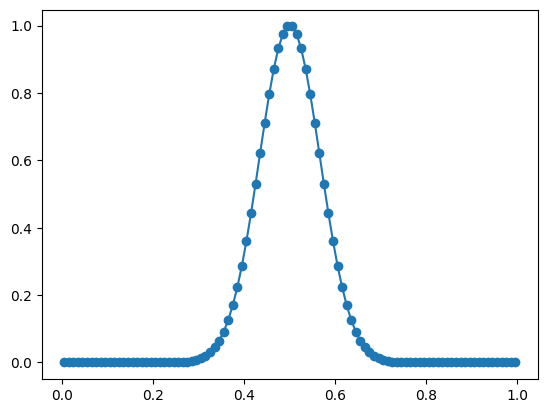

In [ ]:
x=domain.grid.x.centers
bet=100; gam=5; x0=0.5
claw.solution.q[0,:] = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))
claw.solution.q[1,:] = 0.

plt.plot(x, claw.solution.q[0,:],'-o')

This plot represent the initial state of our system for the pressure. It can also represent an initial wave of water.

### Problem-specific parameters
The Riemann solver we've chosen requires some physical parameters to be specified by these lines:

In [ ]:
riemann_solver.cparam

density = 1.0
bulk_modulus = 1.0
impedance = np.sqrt(density*bulk_modulus)
sound_speed = np.sqrt(density/bulk_modulus)

claw.solution.state.problem_data = {
                              'rho' : density,
                              'bulk': bulk_modulus,
                              'zz'  : np.sqrt(density*bulk_modulus),
                              'cc'  : np.sqrt(bulk_modulus/density)
                              }

Two of these parameters are $\rho$ and $K$ in the equations above.  The other two are the impedance $Z = \sqrt{\rho K}$ and sound speed $c = \sqrt{K/\rho}$.  We specify these parameters in a dictionary that belongs to the solution object:

>*Note : Obviously, these parameters are going to differ when it will comes to modelling an ocean wave more accurately, but they will do the trick for a first approximation.*

###Running the simulation
We run the simulation by running this line:

In [ ]:
status = claw.run()

2024-09-13 11:58:14,293 INFO CLAW: Solution 0 computed for time t=0.000000
2024-09-13 11:58:14,310 INFO CLAW: Solution 1 computed for time t=0.020000
2024-09-13 11:58:14,314 INFO CLAW: Solution 2 computed for time t=0.040000
2024-09-13 11:58:14,320 INFO CLAW: Solution 3 computed for time t=0.060000
2024-09-13 11:58:14,324 INFO CLAW: Solution 4 computed for time t=0.080000
2024-09-13 11:58:14,329 INFO CLAW: Solution 5 computed for time t=0.100000
2024-09-13 11:58:14,336 INFO CLAW: Solution 6 computed for time t=0.120000
2024-09-13 11:58:14,340 INFO CLAW: Solution 7 computed for time t=0.140000
2024-09-13 11:58:14,349 INFO CLAW: Solution 8 computed for time t=0.160000
2024-09-13 11:58:14,355 INFO CLAW: Solution 9 computed for time t=0.180000
2024-09-13 11:58:14,360 INFO CLAW: Solution 10 computed for time t=0.200000
2024-09-13 11:58:14,364 INFO CLAW: Solution 11 computed for time t=0.220000
2024-09-13 11:58:14,370 INFO CLAW: Solution 12 computed for time t=0.240000
2024-09-13 11:58:14,37

##1.3 Plotting the results and interpretation
To examine the evolution more thoroughly, it's nice to see all the frames in animation.  We can do this as follows.

In [ ]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(0, 1), ylim=(-0.8, 1.2))

frame = claw.frames[0]
pressure = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
plt.legend(['p','u'])

def fplot(frame_number):
    frame = claw.frames[frame_number]
    pressure = frame.q[0,:]
    velocity = frame.q[1,:]
    line1.set_data(x,pressure)
    line2.set_data(x,velocity)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30, repeat=False)
plt.close()
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

The <font color='lightblue'>blue</font> line represente the <font color='lightblue'>pressure</font> (or the height of the wave for our water approximation) while the <font color='orange'>orange</font> line show the <font color='orange'>velocity</font> of the wave along the $x$-axis.

>*Note : You can navigate frame by frame using the arrows buttons for a more in-depth exam of the results*

As we can see, the initial wave start by splitting itself in two smaller waves going in opposite direction (one with a positive velocity along the $x$-axis and the other with a negative one).

At the midpoint of the simulation, both waves have reach the edges and the velocity null.

Since we specified the boundary conditions as walls, the waves rebounced on the walls and turn around (the respective velocities of the waves are reversed) and merge to remake the initial vage.

**This model fit quite well with the expected wave behaviour even though a diffussion term should be add so that the wave dissipates over time.**


### To go further


*   You can change the boundary conditions to outflow by using `pyclaw.BC.extrap` in the boundary conditions line.
*   Change the grid to use a larger or smaller number of grid cells via `pyclaw.Domain( (0.,), (1.,), (100,))`

>*Note : If you want to change the some parameters in the simulation, youhave to change the code in their dedicated section. Be carefull, you have to re intitialize the controller **FIRST** and then re run all the code lines in the **SAME ORDER** with the changes made*

---

#**2. Shallow water equations in one dimension**
In this section we will modelized a Tsunami-like wave approaching a continental shelf.

This one dimensional example problem consists of a flat ocean floor, linear continental slope, flat continental shelf, and a solid wall reflecting boundary.  

It is designed to illustrate how a tsunami wave is modified as it moves from the deep ocean onto the continental shelf, and the manner in which some of the energy can be trapped on the shelf and bounce back and forth.



##2.1 Set up the equations
In this Section we study a more complex model : The shallow water equations. those are the most accurate when the average depth of the fluid volume is  way smaller than the wavelength. So mathematicly, if $h$ is the depth and $\lambda$ is the wavelenght, we will assume than $ϵ = h/λ \ll 1 $

We will use the following shallow water equations:
$$h_t + (hu)_x  = 0 \\
(hu)_t + (hu^2 + \frac{1}{2}gh^2)_x = 0 $$

Here $h$ is the depth, $u$ is the velocity, and $g$ is a constant representing the force of gravity.

The linearisation of the equations give us:
$$ \eta_t(x,t)  + (h(x)u(x,t))_x = 0 \\
u_t + g\eta_x(x,t) = 0 $$

Where $h(x)$ is the undisturbed fluid depth, $η$
$\ll h(x)$ is the linearized surface elevation (with $\eta = 0$
corresponding to the undisturbed sea level), $u(x,t)$ is
the depth-averaged horizontal velocity, and $g = 9,81 m/s^2$ is the gravitational constant.

Those equation can be rewritten in the linear hyperbolic the form $$q_t(x,t) + A(x)q(x,t)_x = 0$$ Where $q = [η,u]$ is the solution vector and de coefficient matrix A is given by
$$A(x) = \begin{bmatrix} 0 & h(x)  \\ g & 0  \end{bmatrix}$$

This matrix has eigenvalues and corresponding
eigenvectors given by
$$λ_1 = -\sqrt{gh(x)}, \quad  r_1 =\begin{bmatrix} 1\\ -\sqrt{g/h(x)} \end{bmatrix} \\
λ_2 = \sqrt{gh(x)}, \quad  r_2 =\begin{bmatrix} 1\\ \sqrt{g/h(x)} \end{bmatrix}$$

The eigenvalues are the wave speeds of left- and right-going waves. The eigenvectors reveal, form example, that a purely right-going wave on flat
bathymetry with $h(x) \equiv h_0$

Notice that, unlike acoustics the eigenvalues and eigenvectors depend on $q$ via $η$. Because of this, the waves appearing in the Riemann problem move at different speeds and may be either jump discontinuities (shocks) or smoothly-varying rarefaction waves.

These equations are "depth averaged" and neglect vertical velocity and any vertical variations in the horizontal velocity.  **Viscosity and compressibility are neglected, and the pressure is assumed to be hydrostatic.**  Nevertheless, this is a surprisingly effective model for many applications, particularly when the wavelength is long compared to the fluid depth.

The shallow water system is our first example of a nonlinear hyperbolic system; solutions of the Riemann problem for this system consist of two waves (since it is a system of two equations), one being the velocity and the other the depth.

>For more about the resolution of these equations as well as more information about thes behavior of tsunami on steep continental shelf, see this paper:
*Shoaling on Steep Continental Slopes: Relating Transmission and Reflection Coefficients to Green's Law
by J. D. George, D. I. Ketcheson, and R. J. LeVeque, Pure and Applied Geophysics, 2019. [DOI 10.1007/s00024-019-02316-y](https://doi.org/10.1007/s00024-019-02316-y).*

##2.2 Numerical resolution
###Clawpack instalation and import
For this example, we will need the package clawpack along with a fortran compiler. Fortran allow us to compute way faster large data problems.

To install those, we first need to **reset the excusion environment** of this notebook by clicking on the 'réinitialisé l'environnement d'excusions' button on the 'Exécution' tab (in the highest corner of yours sreen).

Once done, you can run this block:

In [ ]:
!git clone git://github.com/clawpack/clawpack.git
%cd /content/clawpack
%pwd
!git checkout v5.7.0     # or an older version; `git tag -l` to list options
!git submodule init      # for repositories pyclaw, clawutil, visclaw, etc.
!git submodule update
%env CLAW=/content/clawpack
!git clone https://github.com/clawpack/apps.git

Cloning into 'clawpack'...
fatal: unable to connect to github.com:
github.com[0: 140.82.113.3]: errno=Connection timed out

[Errno 2] No such file or directory: '/content/clawpack'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
env: CLAW=/content/clawpack
fatal: destination path 'apps' already exists and is not an empty directory.


We then need to set up the plotting setting of the notebook as well as importing all the packages that will be necessary.
We create also a function `show_anim` allowing us to choose which format of animation we want. The `anim.to_html5_video()` option is better if you want to download yours animation but we set the `anim.to_jshtml()` option to plot directly in this notebook.

In [ ]:
%pylab inline

from clawpack.clawutil import nbtools
from IPython.display import FileLink
from clawpack.visclaw import animation_tools
from IPython.display import display, FileLink, FileLinks, HTML

def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
    #html_version = HTML(anim.to_html5_video())
    return html_version

Populating the interactive namespace from numpy and matplotlib


###Setting up of the environment variables
To use the Fortran versions of Clawpack you will need to set the environment variable `CLAW` to point to the top level of clawpack tree.
We will also create some output file and thus we need to specify the working directory which is also the directory where yours output are going to be stored. This path is called `PYTHONPATH`.

In [ ]:
import os, sys
CLAW = os.environ.get('CLAW','/Users/rjl/git/clawpack')
sys.path.append(CLAW)  # add to path so clawpack modules can be found
os.environ['CLAW'] = CLAW
os.environ['PYTHONPATH'] = CLAW  # so Fortran Makefiles work
print ("Clawpack directory:  ",CLAW)
example_dir = CLAW + '/apps/tsunami/shelf1d'
os.chdir(example_dir)
print ("The directory where yours outputs are going to be stored is:", os.getcwd())

Clawpack directory:   /content/clawpack


FileNotFoundError: [Errno 2] No such file or directory: '/content/clawpack/apps/tsunami/shelf1d'

###Instancing the controller
This time we instance the controller in a different way than for our previous example.
We istance it via the two following command lines:

In [ ]:
nbtools.make_exe()
nbtools.make_htmls()

Executing shell command:   make .exe
*** Possible errors, return_code = 2
Done...  Check this file to see output:


/content/compile_output.txt

*** Possible errors, return_code = 2
Done...  Check this file to see output:


/content/htmls_output.txt

See the README.html file for links to input files...


/content/README.html

`nbtools.make_exe()` create the main file that will contain the instructions for the fortran compiler while `nbtools.make_htmls()` did the same but for the plotting fonction that will be used later.

>*Note : You can see those file in yours notebook environment following the path outputed by the last code block (the file navigator is accecible via the file icon on the left)*

We then instance the `setrun` file containing all the parameters for the solve of the equations.
>*Note : You can also acces this file in the same directory as before*

Thoses parameters are the following :
- `Bocean` = depth of ocean (meters below sea level)
- `Bshelf` = depth of continental shelf
- `width` = width of continental slope (linear section connecting floor to shelf)
- `start` = location of start of continental slope



In [ ]:
import setrun
rundata = setrun.setrun()

ModuleNotFoundError: No module named 'setrun'

###Domain
The domain is also set up in the `setrun` file with the following lines:
* `clawdata.lower[0] = -4.000000e+05` set the right edge of the domain
* `clawdata.upper[0] = 0.000000e+00` set the right one
* `clawdata.num_cells[0] = 2000` set the number of frid cells computed




###Boundary conditions
In order to not disturb the right going wave, we set the left boundary condition as `0` so that the left going wave will leave the domain and not be reflected on the right. This is done in the `setrun` file via the line `rundata.clawdata.bc_upper[0] = 'wall'`  

But to better match the reality of a small wave trapped between a shelf and a cost, we set the right boundary condition as a wall. This is also done in the `setrun` file via the line `rundata.clawdata.bc_lower[0] = 'extrap' `

###Problem-specific parameters
* The `initial time` is set at $0$ and the `final time` at $48 000\:s \simeq 13 \:h$
* The `Number of output time` is set at $48$
* Then, $dt = \frac{Δt}{n_{outupt}} = 1000 \:s \simeq 17 \:min$

We also set the Bathymetry parameters by the following block:

In [ ]:
rundata.probdata.Bocean = -4000.
rundata.probdata.Bshelf = -400.
rundata.probdata.width = 1.
rundata.probdata.start = -30.e3 # 30 kilometers offshore
rundata.write()

NameError: name 'rundata' is not defined

##2.3 Plotting the results and interpretation
To plot the resolution, we use those three lines:

The `make_output_and_plots` function will compute the solution and make png file corresponding to each frame in the `plotdir` directory, while the two next lines animate all of the frames.

In [ ]:
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir);
show_anim(anim)

The highest subplot stand for the acual wave seen from the side. While the middle subplot show us the velocity of the wave. The last static plot is the sea floor with a continental shelf.

The initial data is a hump of water with zero velocity everywhere. Note that the intial hump splits into left-going and right-going waves. Juste like our acoustic example. The left-going wave will leave the domain (since "non-reflecting" boundary conditions are used at the left boundary in order not to interfere with the left sided observations).  

The right-going wave hits the continental slope, where some of the wave energy is reflected and some is transmitted onto the shelf.  The transmitted wave reflects off the coastline (a vertical wall in this model). The reflected wave hits the slope again and is partly transmitted out to the ocean, and partly reflected back towards shore. Quite a bit of energy may be trapped on the shelf and bounce back and forth for some time.

Note that the wave propagates more slowly on the shelf than in the deep ocean. In the shallow water equations the wave propagation speed is $\sqrt{gh}$ where $g = 9.81 m/s^2$ is the gravitational acceleration and $h$ is the water depth.  The wave form also gets compressed as it moves onto the shelf because of the slower wave speed.

###To go further
We re run the simulation with other Bathymetry parameters like:

A shallower shelf
```
rundata.probdata.Bshelf = -50.
```
A shallower ocean
```
rundata.probdata.Bocean = -2000.
```
Or with a wide continental slope instead of a step discontinuity
```
rundata.probdata.width = 100.e3
rundata.probdata.start = -130.e3
```

And observed a variation in the speed of the wave trapped as well as in the height of the wave depending on the relative depths and steepness of the slope.

---


#**3. Shallow water equations in two dimentions**
In this section we will go further in our model by trying to apply the shallow water equations shown in the last section in a two dimensional domain. This time we won't neglect viscosity but we still neglected compressibility (and then assume the density of water being constant) and the pressure is still assumed to be hydrostatic.

We will use finite
differences where the momentum equations are taken to be linear, but the
continuity equation is solved in its nonlinear form.



##3.1 Set up the equations
The resulting equations are therefore:

$$u_t +g(\eta)_x - \frac{1}{\rho_0H} = 0 \\
v_t +g(\eta)_y - \frac{1}{\rho_0H} = 0  \\
η_t + ((\eta +H)u)_x + ((\eta +H)u)_y -σ  = 0
$$

Where $H$	is the mean height of the horizontal pressure surface, $σ$ is the height above the lowest point in the cross section at location $x$.
Thoses equations still assume that the fluid is **inviscid and incompressible**.

##3.2 Numerical resolution
We will use this time an **upwind sheme resolution method** to solve our equations.

Once again, we advise you to **reset the excusion environment of this notebook** prior running the following code.
Once done, we can run the following blocks.

We then import alls the module needed and also specify matplotlib to plot the figures within this notebook.

In [ ]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

###Physical parameters
We assume several physical parameters :    
* `g` equal to $9.81 m/s^2$
* The depth of the fluid `H` equal to $100 m$
* The density of the fluid `rho_0` equal to $1024 \:kg/m^3$


In [ ]:
g = 9.81                # Acceleration of gravity [m/s^2]
H = 100                 # Depth of fluid [m]
rho_0 = 1024.0          # Density of fluid [kg/m^3)]

###Computational prameters and domain
* The domain being a $10^6 \:m$ square
* The number of grid point `N_x` and `N_y` equal to $150$ grid cells
* The grid spacing in the $x$ and $y$ direction equal to $\frac{L_x}{N_x - 1} = \frac{1\mathrm{e}{+6}}{150 - 1} = 6711 \: m$
* The time step `dt` is define by the CFL condition of the upwind sheme for a non linear terms, given by this equation  $ dt \leq \frac{dx}{10 \sqrt{gH}} = \frac{6711}{10 \sqrt{9.81 * 100}} = 21 \: s$
* The number of time step `max_time_step` equal tp $5000$

In [ ]:
L_x = 1E+6                           # Length of domain in x-direction
L_y = 1E+6                           # Length of domain in y-direction
N_x = 150                            # Number of grid points in x-direction
N_y = 150                            # Number of grid points in y-direction
dx = L_x/(N_x - 1)                   # Grid spacing in x-direction
dy = L_y/(N_y - 1)                   # Grid spacing in y-direction
dt = 0.1*min(dx, dy)/np.sqrt(g*H)    # Time step (defined from the CFL condition)
time_step = 1                        # For counting time loop steps
max_time_step = 5000                 # Total number of time steps in simulation
x = np.linspace(-L_x/2, L_x/2, N_x)  # Array with x-points
y = np.linspace(-L_y/2, L_y/2, N_y)  # Array with y-points
X, Y = np.meshgrid(x, y)             # Meshgrid for plotting
X = np.transpose(X)                  # To get plots right
Y = np.transpose(Y)                  # To get plots right

###Instancing the arrays solutions
We now define our arrays that will contain the solutions for $u$, $v$, and $η$. Since we use a **Implicite résolution method** we need alos to define the arrays tha will contain the solution in the next time step. Also, because we use an **upwind  scheme** for the $\eta$ solutions, tempory variables need to be define as well.

In [ ]:
u_n = np.zeros((N_x, N_y))      # To hold u at current time step
u_np1 = np.zeros((N_x, N_y))    # To hold u at next time step
v_n = np.zeros((N_x, N_y))      # To hold v at current time step
v_np1 = np.zeros((N_x, N_y))    # To hold v at enxt time step
eta_n = np.zeros((N_x, N_y))    # To hold eta at current time step
eta_np1 = np.zeros((N_x, N_y))  # To hold eta at next time step

# Temporary variables (each time step) for upwind scheme in eta equation
h_e = np.zeros((N_x, N_y))
h_w = np.zeros((N_x, N_y))
h_n = np.zeros((N_x, N_y))
h_s = np.zeros((N_x, N_y))
uhwe = np.zeros((N_x, N_y))
vhns = np.zeros((N_x, N_y))

###Initial and boundary conditions
We choosed the initial values for $u$ and $v$ of $0\: m/s$ with a wall type of bondary condition so that the wave will rebounce on the edges.

We choosed the $\eta$ initial value as an  two dimentinal Gausian fonction $f(x,y) = \exp[-(\frac{(x - x_0)^2}{2\sigma_x ^2} + \frac{(y - y_0)^2}{2\sigma_y ^2})] $ with $x_0$, $y_0$ are the centre coordinate and $σ_x$, $\sigma_y$ are the the width of the function along the both axis, choosed a value of $50000 \:m$.

In [ ]:
# Initial conditions for u and v.
u_n[:, :] = 0.0             # Initial condition for u
v_n[:, :] = 0.0             # Initial condition for u
u_n[-1, :] = 0.0            # Ensuring initial u satisfy BC
v_n[:, -1] = 0.0            # Ensuring initial v satisfy BC

# Initial condition for eta.
sigma_x, sigma_y = 50000, 50000
eta_n = np.exp(-((X-L_x/2.7)**2/(2*(sigma_x)**2) + (Y-L_y/4)**2/(2*(sigma_y)**2)))

###Sampling variables

The following block define a series of list that will contain the samples of ours solution in order to make the plots.

In [ ]:
eta_list = list(); u_list = list(); v_list = list();       # Lists to contain eta and u,v for animation
ts_sample = list(); t_sample = list()                      # Lists of time series and time samples
ts_sample.append(eta_n[int(N_x/2), int(N_y/2)])            # Sample initial eta at center of domain
t_sample.append(0.0)                                       # Add initial time to t-samples
anim_interval = 20                                         # How often to sample for time series
sample_interval = 1000                                     # How often to sample for time series

###Computing the solutions

In [ ]:
t_0 = time.perf_counter()
while (time_step < max_time_step):
      # ------------ Computing values for u and v at next time step --------------
      u_np1[:-1, :] = u_n[:-1, :] - g*dt/dx*(eta_n[1:, :] - eta_n[:-1, :])
      v_np1[:, :-1] = v_n[:, :-1] - g*dt/dy*(eta_n[:, 1:] - eta_n[:, :-1])

      v_np1[:, -1] = 0.0      # Northern boundary condition
      u_np1[-1, :] = 0.0      # Eastern boundary condition
      # -------------------------- Done with u and v -----------------------------

      # --- Computing arrays needed for the upwind scheme in the eta equation.----
      h_e[:-1, :] = np.where(u_np1[:-1, :] > 0, eta_n[:-1, :] + H, eta_n[1:, :] + H)
      h_e[-1, :] = eta_n[-1, :] + H

      h_w[0, :] = eta_n[0, :] + H
      h_w[1:, :] = np.where(u_np1[:-1, :] > 0, eta_n[:-1, :] + H, eta_n[1:, :] + H)

      h_n[:, :-1] = np.where(v_np1[:, :-1] > 0, eta_n[:, :-1] + H, eta_n[:, 1:] + H)
      h_n[:, -1] = eta_n[:, -1] + H

      h_s[:, 0] = eta_n[:, 0] + H
      h_s[:, 1:] = np.where(v_np1[:, :-1] > 0, eta_n[:, :-1] + H, eta_n[:, 1:] + H)

      uhwe[0, :] = u_np1[0, :]*h_e[0, :]
      uhwe[1:, :] = u_np1[1:, :]*h_e[1:, :] - u_np1[:-1, :]*h_w[1:, :]

      vhns[:, 0] = v_np1[:, 0]*h_n[:, 0]
      vhns[:, 1:] = v_np1[:, 1:]*h_n[:, 1:] - v_np1[:, :-1]*h_s[:, 1:]
      # ------------------------- Upwind computations done -------------------------

      # ----------------- Computing eta values at next time step -------------------
      eta_np1[:, :] = eta_n[:, :] - dt*(uhwe[:, :]/dx + vhns[:, :]/dy)

      # ----------------------------- Done with eta --------------------------------

      u_n = np.copy(u_np1)        # Update u for next iteration
      v_n = np.copy(v_np1)        # Update v for next iteration
      eta_n = np.copy(eta_np1)    # Update eta for next iteration

      time_step += 1

      # Samples for Hovmuller diagram and spectrum every sample_interval time step.
      if (time_step % sample_interval == 0):
          ts_sample.append(eta_n[int(N_x/2), int(N_y/2)])     # Sample center point for spectrum
          t_sample.append(time_step*dt)                       # Keep track of sample times.

      # Store eta and (u, v) every anin_interval time step for animations.
      if (time_step % anim_interval == 0):
          print("Time: {:.2f} hours \t Step: {} / {}".format(time_step*dt/3600, time_step, max_time_step))
          u_list.append(u_n)
          v_list.append(v_n)
          eta_list.append(eta_n)
print("Main computation loop done!\nExecution time: {:.2f} s".format(time.perf_counter() - t_0))

##3.3 Plotting the results and interpretation

In [ ]:
def eta_animation(X, Y, eta_list, frame_interval, filename):
    """Function that takes in the domain x, y (2D meshgrids) and a list of 2D arrays
    eta_list and creates an animation of all eta images. To get updating title one
    also need specify time step dt between each frame in the simulation, the number
    of time steps between each eta in eta_list and finally, a filename for video."""
    fig, ax = plt.subplots(1, 1)
    plt.xlabel("x [m]", fontname = "serif", fontsize = 12)
    plt.ylabel("y [m]", fontname = "serif", fontsize = 12)
    pmesh = plt.pcolormesh(X, Y, eta_list[0], vmin = -0.7*np.abs(eta_list[int(len(eta_list)/2)]).max(),
        vmax = np.abs(eta_list[int(len(eta_list)/2)]).max(), cmap = plt.cm.RdBu_r)
    plt.colorbar(pmesh, orientation = "vertical", label ='$\eta$ [m]')

    def update_eta(num):
        ax.set_title("Surface elevation $\eta$ after t = {:.2f} hours".format(
            num*frame_interval/3600), fontname = "serif", fontsize = 16)
        pmesh.set_array(eta_list[num][:-1, :-1].flatten())
        return pmesh,

    anim = animation.FuncAnimation(fig, update_eta,
        frames = len(eta_list), interval = 10, blit = False)
    return anim    # Need to return anim object to see the animation

def velocity_animation(X, Y, u_list, v_list, frame_interval, filename):
    """Function that takes in the domain x, y (2D meshgrids) and a lists of 2D arrays
    u_list, v_list and creates an quiver animation of the velocity field (u, v). To get
    updating title one also need specify time step dt between each frame in the simulation,
    the number of time steps between each eta in eta_list and finally, a filename for video."""
    fig, ax = plt.subplots(figsize = (8, 8), facecolor = "white")
    plt.title("Velocity field $\mathbf{u}(x,y)$ after 0.0 days", fontname = "serif", fontsize = 19)
    plt.xlabel("x [km]", fontname = "serif", fontsize = 16)
    plt.ylabel("y [km]", fontname = "serif", fontsize = 16)
    q_int = 3
    Q = ax.quiver(X[::q_int, ::q_int]/1000.0, Y[::q_int, ::q_int]/1000.0, u_list[0][::q_int,::q_int], v_list[0][::q_int,::q_int],
        scale=0.2, scale_units='inches')

    # Update function for quiver animation.
    def update_quiver(num):
        u = u_list[num]
        v = v_list[num]
        ax.set_title("Velocity field $\mathbf{{u}}(x,y,t)$ after t = {:.2f} hours".format(
            num*frame_interval/3600), fontname = "serif", fontsize = 19)
        Q.set_UVC(u[::q_int, ::q_int], v[::q_int, ::q_int])
        return Q,

    anim = animation.FuncAnimation(fig, update_quiver,
        frames = len(u_list), interval = 10, blit = False)
    mpeg_writer = animation.FFMpegWriter(fps = 24, bitrate = 10000,
        codec = "libx264", extra_args = ["-pix_fmt", "yuv420p"])
    fig.tight_layout()
    anim.save("{}.mp4".format(filename), writer = mpeg_writer)
    return anim

def eta_animation3D(X, Y, eta_list, frame_interval, filename):
    fig = plt.figure(figsize = (8, 8), facecolor = "white")
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, eta_list[0], cmap = plt.cm.RdBu_r)

    def update_surf(num):
        ax.clear()
        surf = ax.plot_surface(X/1000, Y/1000, eta_list[num], cmap = plt.cm.RdBu_r)
        ax.set_title("Surface elevation $\eta(x,y,t)$ after $t={:.2f}$ hours".format(
            num*frame_interval/3600), fontname = "serif", fontsize = 19, y=1.04)
        ax.set_xlabel("x [km]", fontname = "serif", fontsize = 14)
        ax.set_ylabel("y [km]", fontname = "serif", fontsize = 14)
        ax.set_zlabel("$\eta$ [m]", fontname = "serif", fontsize = 16)
        ax.set_xlim(X.min()/1000, X.max()/1000)
        ax.set_ylim(Y.min()/1000, Y.max()/1000)
        ax.set_zlim(-0.3, 0.7)
        plt.tight_layout()
        return surf,

    anim = animation.FuncAnimation(fig, update_surf,
        frames = len(eta_list), interval = 10, blit = False)
    mpeg_writer = animation.FFMpegWriter(fps = 24, bitrate = 10000,
        codec = "libx264", extra_args = ["-pix_fmt", "yuv420p"])
    anim.save("{}.mp4".format(filename), writer = mpeg_writer)
    return anim    # Need to return anim object to see the animation

In [ ]:
plt.ioff()
eta_anim = eta_animation(X, Y, eta_list, anim_interval*dt, "eta")
HTML(eta_anim.to_jshtml())

We can see the initial wave get rebounce on the walls of the domain and interact with one another. But since we didn't embed a diffusion term, the energy stay in the system. It follows that at the end of the simulation, the waves are still quite strong. Which is not very realistic. Therefore, in order to improve our model, an embedding of an **diffusion term** is to be considerate.
>*Note : While shearching on web for the modelisation of shallow water in two demention we also see that some model inclued the **friction** of the water with the sea floor or the influence of the wind on the waves, but we won't go that far in this notebook.*

###To go further
For this example we didn't try to change the pysicals parameters since those are physical constants and therefore their value are quite well define in the scientific community.

But instead we tried to plot the result in a fancier  way. We made a 3D plot of the surface as well as a vectoriel plot of the velocity field.

>*Note : Because of the important size of those two graphes, we can directly plot them within this notebook as HTML file. We instead save them as two mp4 file in the current working directory (accessible by clicking on the file icon on the right). We named them `velocity.mp4` and `eta_suraface.mp4`*

You can make those graphs by running the following block (It can take a couple of minutes to finish executing). The two images output within this notebook is the first frame of the animations.

In [ ]:
plt.ion()
eta_animation3D(X, Y, eta_list, anim_interval*dt, "eta_surface")
velocity_animation(X, Y, u_list, v_list, anim_interval*dt, "velocity")

---



# **4. Tsunami case study : grid refinement**
Now that we know how to modelise quite well waves in two dimention, we are going to have a closer look at some real case of tsunami. We will first use this case to illustrate the grid rafinement method. We will then use the model to observe waves that are been trapped on the continental shelf.

##4.1 Set up the equations
This example use the same equations and assumptions as the previous example that is to say the two **dimentional shallow water equations**.

The main difference here is that we will use the 2D shallow water equations on a **spherical surface**. We will thus use a different grid, We describe a **rectangular quadrilateral grid** for solving PDEs in spherical domains.

grid obtained by a simple mapping from a Cartesian grid on a square domain. Two lines of grid cells are shaded to help visualize the mapping. This mapping is obtained by taking each point on the square [−1, 1] × [−1, 1] and projecting it radially to the unit circle. All points along the radial line through this point are rescaled linearly and so the square is contracted into a circle. This mapping has the property that the grid cells along the 45 degree lines end up being nearly triangular, with two edges of the quadrilateral cell nearly colinear even though in computational space these edges are orthogonal.

If we want to consider a computational
point $(x_c, y_c)$ that satisfies $x_c > 0$ and $|y_c| < x_c ≡ d$, for example, which lies in the eastern sector.
The vertical line segment between $(d, −d)$ and $(d, d)$ is mapped to a circular arc of radius $R(d)$ that passes through the points $(D(d), −D(d))$ and
$(D(d), D(d))$. The mapping is fully defined by the functions $R(d)$ and $D(d)$ as discussed further below. It also is easy to compute that the center of this circle of radius $R(d)$ is

$$(x_0, y_0)=(D(d)−\sqrt{R(d)^2 − D(d)^2} \:, 0)$$

The point $(x_c, y_c)$ is then mapped to:
$$ y_p = y_c \frac{D(d)}{d} \\
x_p = D(d) = \sqrt{R(d)^2 - D(d)^2} + \sqrt{R(d)^2 - y_p^2} \\
$$

For tree dimentional domain, we also need to map the point $z$ as follow
$$z_p = \sqrt{1 - (x_p^2 + y_p^2)}$$

then the points (xp,yp,zp) lie on the upper hemisphere. We can apply a similar mapping to points in the computational domain [−3, −1]×[−1, 1] to map these points to the lower hemisphere. The two mappings together map the rectangle [−3, 1]×[−1, 1] to the surface of the sphere.

>For more information about the definition of rectangular grid for sphérical application see "*Logically Rectangular Grids and Finite Volume Methods for PDEs in
Circular and Spherical Domains. By Donna A. Calhoun, Christiane Helzel, and Randall J. LeVeque SIAM Review 50 (2008), 723-752. [https://doi.org/10.1137/060664094](https://epubs.siam.org/doi/10.1137/060664094)*"

##4.2 Numerical resolution
We will use the `Geoclaw` repositories of `Clawpack` to modelize and plot our tsunami

Once again, we advise you to **reset the excusion environment of this notebook** prior running the following code.

Once done, we can run the following blocks.

In [ ]:
!git clone git://github.com/clawpack/clawpack.git
%cd /content/clawpack
%pwd
!git checkout v5.7.0     # or an older version; `git tag -l` to list options
!git submodule init      # for repositories pyclaw, clawutil, visclaw, etc.
!git submodule update
%env CLAW=/content/clawpack
!git clone https://github.com/clawpack/apps.git

Cloning into 'clawpack'...


We then set the usual parameters so that the clawpack library works in this notebook.

We also re define the `show_anim` function to make HTML annimated plots.

In [ ]:
%pylab inline
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML
import os
import clawpack

def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
    #html_version = HTML(anim.to_html5_video())
    return html_version

###Setting up of the environment variables
Since this example alos use the Fortran versions of Clawpack you will still need to set the environment variable `CLAW` to point to the top level of clawpack tree.

We will also again create some output file and thus we need once more, to specify the working directory which is also the directory where yours output are going to be stored. This path is called `PYTHONPATH`.

In [ ]:
import os, sys
CLAW = os.environ.get('CLAW')
sys.path.append(CLAW)  # add to path so clawpack modules can be found
os.environ['CLAW'] = CLAW
os.environ['PYTHONPATH'] = CLAW  # so Fortran Makefiles work
print ("Clawpack directory:  ",CLAW)
example_dir = CLAW + '/apps/notebooks/geoclaw/chile2010a'
os.chdir(example_dir)
print ("The directory where yours outputs are going to be stored is:", os.getcwd())

###Instancing the controller
We instance the controller the same way that for the second example.
We instance it via the two following command lines:

In [ ]:
nbtools.make_exe(new=True)

We next import the `setrun` file that containe all the parameters for the simulation. We will store the parameter in a `ClawRunData` object name `rundata`. In this way, it is easier to changes our futur parameters.

In [ ]:
from setrun import setrun
rundata = setrun()

###Domain
Since we will use some geodata to make our topography mapping, the values passed in the difinition of the domain will be latitute and longitude. Our domain will go frome $0°$ nort latitute to $-60°$ south latitude and from $-60°$ to $-120°$ west longitude

We also set the number of grid cell of $30$ by $30$. Each grid cell is thus $2°$ (opproximately $220km$)

In [ ]:
rundata.clawdata.lower[0] = -120.0      # west longitude
rundata.clawdata.upper[0] = -60.0       # east longitude

rundata.clawdata.lower[1] = -60.0       # south latitude
rundata.clawdata.upper[1] = 0.0         # north latitude

rundata.clawdata.num_cells[1] = 30      #number of grid cells along x axis
rundata.clawdata.num_cells[0] = 30      #number of grid cells along y axis

###Boundary conditions
Since we want the most realistic model possible, we set the boundary condition to `extrap` for the four axes wich simulate a non-reflecting outflow.

In [ ]:
rundata.clawdata.bc_lower[0] = 'extrap'  #BC along x axis
rundata.clawdata.bc_upper[0] = 'extrap'

rundata.clawdata.bc_lower[1] = 'extrap'  #BC along y axis
rundata.clawdata.bc_upper[1] = 'extrap'

rundata.write()

###Generating topography
In order to have a clean représenation of the Chile coast, geoclaw can dowload some topography data and plot them as continent and sea. This is done via the `maketopo.py` file.


In [ ]:
  %run maketopo.py

##4.3 Plotting the  first results

In [ ]:
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir);
show_anim(anim)

We can see that those resultas are verry coarse and not verry helpfull since the grid resolution is quitte low. We thus need to imporve that resolution.

##4.4 Better grid with adaptadive refinement
Experiment 1 above was run without grid refinement on a 30 by 30 grid. In order to improve the grid resolution we could change the parameters directy in the Domain section via those lines

```
clawdata.num_cells[0] = 30
clawdata.num_cells[1] = 30
```



But **over much of the domain nothing is happening**, so a more efficient approach is to leave the resolution of this coarsest level 1 grid alone and instead add an additional level of refinement **only where the wave is present.**

To do so, the `amr_levels_max` parameter allow us to choose the maximum level of precision with which the space and time grid with be set. The following line change the initinal value $1$ to $2$ and re run the simulation.

>*Note : For more information about `AMR` algorithm used here see the [clawpack documentation](http://www.clawpack.org/refinement.html#specifying-amr-regions)*

Going from $1$ to $2$ means that the grid will be 2 times finer than Level 1 grids in each direction. They will also be 2 times finer in $t$, meaning two time steps must be taken on each Level 2 grid for every time step on Level 1. This is handled automatically within GeoClaw. We just need to specify the `refinement_ratios` along $x$ , $y$, and $t$ with the tree lines below.

In [ ]:
rundata.amrdata.amr_levels_max = 2
rundata.amrdata.refinement_ratios_x = [2]  #refinement ratios along x
rundata.amrdata.refinement_ratios_y = [2]  #refinement ratios along y
rundata.amrdata.refinement_ratios_t = [2]  #refinement ratios along t
rundata.write()

We can now plot the result and see what happend.

In [ ]:
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir)
show_anim(anim)

Notice several things in this animation:

* There are generally several patches of grids at Level 2 that might or might not be contiguous
* The location of the patches changes with time to follow (parts of) the tsunami.
* Some parts of the tsunami are not resolved on Level 2 at later times.

This is due to the way the adaptative grid detect the wave and weither or not it's relavent to increase the grid resolution. Indeed, we are simply flagging coarse cells as needing refinement whereever the amplitude of the surface (relative to sea level) is above some tolerance. By making the tolerance smaller, we will cause more of the domain to be refined to Level 2 at letter times. This tolerance is fixed at $0.1$ in the `setrun` file:
```
refinement_data.wave_tolerance = 0.1
```
And can be change to $0.02$ via this line:


In [ ]:
rundata.refinement_data.wave_tolerance = 0.02
rundata.write()

If we re run the simulation and plot the results:

In [ ]:
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir)
show_anim(anim)

The grid indeed get finner almost everywhere.

##4.5 Adding a third level
Let's add a third level refining by another factor of two in each dimension going from Level $2$ to Level $3$. Do this by changing the `amr_levels_max` parameter to $3$ and adding the `refinement_ratios` of the transition from the level $2$ to the level $3$.
>*Note :  We have to keep the refinement ratio of the transition from the level $1$ to $2$, so we end up with a list of two refinement ratios.*

In [ ]:
rundata.amrdata.amr_levels_max = 3
rundata.amrdata.refinement_ratios_x = [2,2]
rundata.amrdata.refinement_ratios_y = [2,2]
rundata.amrdata.refinement_ratios_t = [2,2]

If we run the code simulation and plot the results.

In [ ]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir)
show_anim(anim)

Note that at Level 3 we are not plotting the grid lines (which would be so dense they hide the wave). Instead only the patch boundaries are shown. Plotting behavior is controlled by parameters set in `setplot.py` file.

##4.6 Restricting or forcing refinement in regions
In the last experiment we have resolved the tsunami fairly well everywhere. The refinement criterion is simply the amplitude of the wave.

In many applications we do not need to refine equally well everywhere, e.g. if we are only interested in modeling the effect of the tsunami on one particular coastline. We would then like to restrict the regions where refinement to a certain level is allowed.

We might also have particular regions where we want to **force** refinement to some level, over some time period. For example around the earthquake source region, or a region on the coast where we want fine grids even if the tsunami is small there.

GeoClaw allows specifying rectangular regions in space-time over which refinement is required to be at least to Level  $L1$  and at most to level  $L2$ . Multiple regions can be specified, and this can be used in conjunction with flagging based on amplitude (whether a point is refined only to  $L1$  or to some higher level  $≤L2$  depends on the amplitude). If a point lies in more than one region, the maximum of  $L1$  values and the maximum of the  $L2$  values for each region are used as limits.

In order to do so, we first need to define a list that will countained our regions. We can then define ours regions as a list with the following objects:
```
region_list = [min_amr_level, max_amr_level, t1, t2, x1, x2, y1, y2]
```



In [ ]:
rundata.regiondata.regions = []  # empty list of regions

# Allow only level 1 as default everywhere:
rundata.regiondata.regions.append([1, 1, 0., 1e9, -180, 180, -90, 90])

# Force refinement around earthquake source region for first hour:
rundata.regiondata.regions.append([3, 3, 0., 3600., -85,-72,-38,-25])

# Allow up to level 3 in northeastern part of domain:
rundata.regiondata.regions.append([1, 3, 0., 1.e9, -90,-60,-30,0])

 The first added list correspond to a region of maximum level of $1$ anywhere. This is the smaller level of our grid.

The second added list forces refinement to level $3$ around the earthquake but only for the first $3600$ seconds.

The last added list allows up to $3$ levels over the northeastern part of the domain ($x>−90 \:,\: y>−30$ ) which might be appropriate if we were only interested in the impact on the Peru coast, for example.

We can re run the simulation and plots the results:

In [ ]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir)
show_anim(anim)

---

#**5. Tsunami case study : Comparaison with data**
In this example, we will focus our attention on several gauges.  We will first look at an **ocean gauge**, Then we will replace this with a **gauge off the coast** of Peru to better observe **edge waves that are trapped on the continental shelf** in this region.

We will first calculate the solution for the sea surface at each gauge and then compare these solutions with the actual data that was recorded during the earthquake.

For this section, we will use the same equations as before, the only difference is that we will use a level $3$ grid refined by a factor $6$ relative to the level $2$.
>*Note : This parameter has allready been set in the `setrun` file so we won't need to specify it in our code later.*

The gauge's data will from the [32412](http://www.ndbc.noaa.gov/station_page.php?station=32412) one. and they are constituted pressure variation on the sea floor.



##5.1 Full domain plot
To better visualize the position of our two gauges, we will start by plotting the full domain right after having set up our simulation and add our two gauges on the domain.

###Import and notebook setup
As always, we advise you to **reset the excusion environment of this notebook** prior running the following code.

Once done, we can run the following blocks to install the packages and set up the environment variables.

In [ ]:
!git clone git://github.com/clawpack/clawpack.git
%cd /content/clawpack
%pwd
!git checkout v5.7.0    # or an older version; `git tag -l` to list options
!git submodule init      # for repositories pyclaw, clawutil, visclaw, etc.
!git submodule update
%env CLAW=/content/clawpack
!git clone https://github.com/clawpack/apps.git
!pip install JSAnimation

In [ ]:
import os, sys
CLAW = os.environ.get('CLAW')
sys.path.append(CLAW)  # add to path so clawpack modules can be found
os.environ['CLAW'] = CLAW
os.environ['PYTHONPATH'] = CLAW  # so Fortran Makefiles work
print ("Clawpack directory:  ",CLAW)
example_dir = CLAW + '/apps/notebooks/geoclaw/chile2010b'
os.chdir(example_dir)
print ("Directory where this notebook is located:  ", os.getcwd())

In [ ]:
%pylab inline
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML, Image
import os
import clawpack

def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
    #html_version = HTML(anim.to_html5_video())
    return html_version

###Instancing the controller
We do this the same way as before

In [ ]:
nbtools.make_exe(new=True)

We also import the `setrun` file that containe all the parameters for the simulation and store it in variable named `rundata`, just like previously.

In [ ]:
from setrun import setrun
rundata = setrun()
rundata.write()

###Parameters and topography
Since the goal of this section is to compare our model to actual data, we will use the **same parameters** as in the fourth example.

We will also obviously use the **same topography data**.

In [ ]:
%run maketopo.py

###Adding the two gauges
We first need to record time series at the gauge by happening list defined in this manner:
```
gauge = [gauge_number, x, y, t1, t2]
```
With `x, y` are the longitude and latitude of the gauge location, and `t1, t2` specify the time range over which we want to record at this gauge.
>*Note : Those two gauges are **virtual ones**. they are just point where the sea level are going to be calculated over time*

In [ ]:
from clawpack.amrclaw.data import GaugeData
rundata.replace_data("gaugedata", GaugeData())  # clear old gauge data
rundata.gaugedata.gauges = []   # empty list
rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10])
rundata.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10])

###plot
As you can see, the gauge 32412 is located in deep ocean while de 123 one is placed at the cost.

In [ ]:
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir, figno=0)
show_anim(anim)

###Gauge plot
This simulation also calculate the evolution of the ocean surface at the two gauges and plot it on a one dimentional plot this way. Those results are coarse because the we didn't cahnge the `output_style`  nor set a finer $dt$ yet.

In [ ]:
import matplotlib.image as mpimg
from matplotlib import rcParams
rcParams['figure.figsize'] = 15 ,9

# read images
img_A = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge32412fig300.png')
img_B = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge0123fig300.png')

# display images
fig, ax = plt.subplots(1,2)
fig.suptitle("Surface prediction with default parameters", y=0.8, size = 20)
plt.tight_layout()
ax[0].imshow(img_A); ax[0].axis('off')
ax[1].imshow(img_B); ax[1].axis('off')

Note that the values for the surface only start to  rise from $3 \:h$. This is normal since the wave took 3 hours to arrive at the position of the gauge.

##5.2 Get better results
We will focus us now more on two gauges data predictions.
In order to do so, we will change some parameters to have sharpened results.

###Changing the output style
In our case we start at $3.5$ hours and go to `1e10 `(effectively infinite, i.e. to the end of the computation).

We also want to go out to a later time to see the oscillations we expect at this gauge, and we want to output more frequently to see how they propagate in looking at the animation made from time frames. But waves don't reach this coast until about $3.5$ hours into the simulation, so rather than using equally spaced times from `t = 0`, let's use a different `output_style` that allows setting a specific set of output times.

The second line set the time at which we want the solution to be plotted. Here we set 18 (`19`-1) output frames, from `3.5` to `8` hours as an array define this way.

```
time_array = linspace(t_0, t_final, n_frames)
```
 The time between each outupt is then $dt = \frac{Δt}{N_{output}} = \frac{8 - 3.5}{18} = 0.25 \:h = 15 \: min $.

In [ ]:
rundata.clawdata.output_style = 2  #Changing the defaul t0 to the start of our linspace
rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.

In [ ]:
rundata.write()
outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
anim = animation_tools.animate_from_plotdir(plotdir, figno=1)
show_anim(anim)

Note that there are **large waves** (<font color='red'>dark red</font> and <font color='blue'> blue</font>) that **propagate up and down along the coast**. This is because the **continental shelf** along the coast. Here, it is fairly broad and traps waves due to reflections at the steep continental slope as seen in the **second example of this notebook**.

###Gauges plot with new time series
We can better visualize the surface predicted at the gauges with a better resolution.

In [ ]:
rcParams['figure.figsize'] = 15 ,9

# read images
img_A = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge32412fig300.png')
img_B = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge0123fig300.png')

# display images
fig, ax = plt.subplots(1,2)
fig.suptitle("Surface prediction with new parameters", y=0.8, size = 20)
plt.tight_layout()
ax[0].imshow(img_A);ax[0].axis('off')
ax[1].imshow(img_B); ax[1].axis('off')

##5.3 Comparaison with real data
The final step of the modeling process is to confront our model with actual data to see how the model perform.

In order to do so we managed to get real data from the 32412 gauges from a txt file in the Geoclaw depository. The file contained the data strating from 06:34 UTC to 15:34 UTC

In [ ]:
from setplot import setplot
plotdata = setplot()
plotdata.outdir = '_output'
claw_g32412 = plotdata.getgauge(32412)
eta = claw_g32412.q[3,:]
real_g32412 = np.loadtxt("/content/clawpack/geoclaw/examples/tsunami/chile2010/32412_notide.txt")
a, b = 250, 802
t2 = linspace(0,9,b-a)
plot(t2, real_g32412[a:b,1], label ="Real data")
t = linspace(1.95,8.4,eta.shape[0])
plt.axhline(y=0, color='black')
plot(t, eta, label = 'Predicted data')
plt.legend()
xlim(0,9)
ylim(-0.3,0.3)
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 32412')

The <font color='lightblue'>blue</font> line represente the <font color='lightblue'>obeserved data</font> (or the height of the wave for our water approximation) while the <font color='orange'>orange</font> line show the <font color='orange'>modelled data</font>.

We can see that our model predicts quite accurately. There is still some discrepancy between the predicted and observed values, but this could probably be reduced by decreasing the time interval between the calculations.



##5.4 Stability tests of our model
In order to asses the stability of our model, we will change the value of some parameters and see how it's affect the final results.

As a reminder, the parameters used in this model are the following :
* `gravity` $g$ set at $9.81 \; m/s^2$
* `rho` the density of water $ρ_w$ set at $1025 \; kg/m^3$
* `rho_air` the density of air $\rho_{air}$ set at $1.15 \; kg/m^3$
* `ambient_pressure`the atmospheric pressure $p$ set at $101300 \; Pa$
* `earth_radius` set at $6367.5\; km$

By changing each of those parameters one by one we would be able to asses the parameter(s) that lead to the biggest change in our results and therefore pay particular attention to it/them to have the most accurate model.

We chose to apply the same relative increase of each parameters of $10 \%$, which lead to thoses values :  
* `gravity` $g$ set at $10.79 \; m/s^2$
* `rho` the density of water $ρ_w$ set at $1127.5 \; kg/m^3$
* `rho_air` the density of air $\rho_{air}$ set at $1.265 \; kg/m^3$
* `ambient_pressure`the atmospheric pressure $p$ set at $111430 \; Pa$
* `earth_radius` set at $7004.25\; km$

The following bloc compute the solutions for each change in our parameters, since we have to redo the somulation six times, the execution take some time(about 6 minutes) to finish.

In [ ]:
new_param = {"gravity":10.79, "rho":10127.5, "rho_air":1.265, "ambient_pressure":
             111430, "earth_radius":7004250}
plot_list = list()

for key in new_param.keys():
  rundata = setrun()
  rundata.clawdata.output_style = 2
  rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.
  comand = f"rundata.geo_data.{str(key)} = {new_param[key]}"
  exec(comand)
  rundata.write()
  print(f"\n Computing simulation with '{comand}' ... \n")
  outdir,plotdir = nbtools.make_output_and_plots(verbose=False)
  img_A = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge32412fig300.png')
  img_B = mpimg.imread('/content/clawpack/apps/notebooks/geoclaw/chile2010b/_plots/gauge0123fig300.png')
  plot_list.append((img_A, img_B))

In [ ]:
for i in range(len(plot_list)):
  fig, ax = plt.subplots(1,2)
  title = f"Surface prediction with {list(new_param.keys())[i]} = {list(new_param.values())[i]}"
  fig.suptitle(title,y=0.8, size = 20 )
  img_A, img_B = plot_list[i]
  plt.tight_layout()
  ax[0].imshow(img_A);ax[0].axis('off')
  ax[1].imshow(img_B); ax[1].axis('off')

We can see than the **solutions remain stables** regardless of the parameters we have changed. This means that our model is stable wich is logic since those shallow water equations are frequently used in the scientific community.

We changed afterward our paramter by a $10$ factor in order to see a difference in the output and we say that the moste sensible parameters are the gravity and the earth radius.Those two parameters leaded to a large output variation but even a change of $10$ times of the density and pressure did not lead to any significant difference in output.